In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.datasets import make_regression
from sklearn.metrics import *
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier, XGBRegressor
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

In [2]:
def target_encoding(data, column, target):
    
    grouped = data[[column,target]].groupby(column,as_index=False).mean()
    empty_dict = {}
    for i in range(len(grouped)):
        empty_dict[grouped.iloc[i,0]]=grouped.iloc[i,1]
    data[column]=data[column].map(lambda x: empty_dict[x])
    
    return data

In [3]:
df=pd.read_csv('sample.csv')

In [4]:
le = LabelEncoder()
for col in df.select_dtypes(include='O').columns:
    df[col]=le.fit_transform(df[col])

In [5]:
#for col in df.select_dtypes(include='O').columns:
 #   df[col]=target_encoding(df,col,'price')

In [6]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,price_bin,volume
0,0,0.23,2,1,3,61.5,55.0,326.0,0.0,38.202030
1,1,0.21,3,1,2,59.8,61.0,326.0,0.0,34.505856
2,2,0.23,1,1,4,56.9,65.0,327.0,0.0,38.076885
3,3,0.29,3,5,5,62.4,58.0,334.0,0.0,46.724580
4,4,0.31,1,6,3,63.3,58.0,335.0,0.0,51.917250


In [7]:
for col in df.columns:
    df[col]=df[col].astype(float)

In [8]:
def upsample_classes(data, target):
    
    lst = list(data[target].unique())
    
    classes = []
    for c in lst:
        classes.append(data[data[target]==c])
    
    length = 0
    class_lab = None
    for c in classes:
        if len(c)>length:
            length=len(c)
            class_lab = c
    class_lab = class_lab[target].unique()[0]
    
    regroup = pd.concat(classes)
    maj_class = regroup[regroup[target]==class_lab]

    lst.remove(class_lab)
    
    new_classes=[]
    for i in lst:
        new_classes.append(resample(data[data[target]==i],replace=True, n_samples=len(maj_class)))

    minority_classes = pd.concat(new_classes)
    upsample = pd.concat([regroup[regroup[target]==class_lab],minority_classes])

    return upsample

In [9]:
def classification_model(X,y,method,target,test_balance = False):
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=14)
    
    train = pd.concat([X_train,y_train],axis=1)
    
    train_balanced = upsample_classes(train,target)
    
    X_train = train_balanced.drop(target, axis=1)
    y_train = train_balanced[target]
    
    if test_balance == True:
        test = pd.concat([X_test,y_test],axis=1)
        test_balanced = upsample_classes(test,  target)
        X_test = test_balanced.drop(target, axis=1)
        y_test = test_balanced[target]
    
    method.fit(X_train,y_train)
    p = method.predict(X_test)
        
    print('accuracy score')
    print(f1_score(y_test, p ,average='micro'))
    print('-'*20)
    
    plt.figure(figsize=(15,8))
    sns.heatmap(confusion_matrix(y_test,p),annot=True)
    plt.tight_layout()
    plt.show()

In [10]:
def classification(X_tr,y_tr,X_te,y_te,method):    
    
    method.fit(X_tr,y_tr)
    p_train = method.predict(X_tr)
    p_test = method.predict(X_te)
        
    print('train f1 score')
    print(f1_score(y_tr, p_train ,average='micro'))
    print('test f1 score')
    print(f1_score(y_te, p_test ,average='micro'))
    print('-'*20)
    
    plt.figure(figsize=(15,6))
    sns.heatmap(confusion_matrix(y_te,p_test),annot=True)
    plt.tight_layout()
    plt.show()

In [11]:
sgdc=SGDClassifier(random_state=14)
lr=LogisticRegression(random_state=14)
knn=KNeighborsClassifier()
svm=SVC(random_state=14)
svc=LinearSVC(random_state=14)
gnb=GaussianNB()
rfc=RandomForestClassifier(random_state=14)
dt=DecisionTreeClassifier(random_state=14)
xgbc=XGBClassifier(random_state=14)

In [12]:
df.drop(['Unnamed: 0','price'],axis=1,inplace=True)

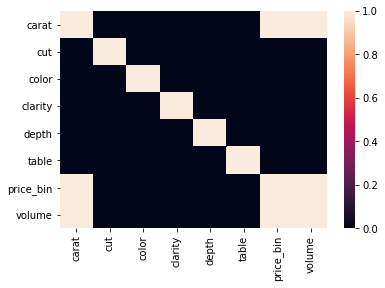

In [13]:
sns.heatmap(abs(df.corr())>=0.7)

In [14]:
X=df.drop(['price_bin'],axis=1)

In [15]:
y=df.price_bin

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=14)

In [17]:
y_train.value_counts()

0.0    29279
1.0     6978
2.0     2651
3.0     1547
Name: price_bin, dtype: int64

In [18]:
X_train_1, y_train_1 = make_imbalance(X_train, y_train, sampling_strategy={0: 1500, 1: 1500, 2: 1500, 3: 1500},random_state=14)

In [19]:
train = pd.concat([X_train,y_train],axis=1)

train_balanced = (upsample_classes(train,'price_bin'))

X_train_2 = train_balanced.drop(['price_bin'],axis=1)
y_train_2 = train_balanced.price_bin

In [20]:
smote = SMOTE(random_state = 14)
X_train_3, y_train_3 = smote.fit_sample(X_train, y_train)

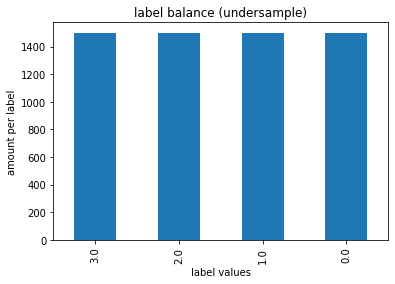

In [21]:
y_train_1.value_counts().plot(kind='bar')
plt.title('label balance (undersample)')
plt.xlabel('label values')
plt.ylabel('amount per label')
plt.show()

In [19]:
test = pd.concat([X_test,y_test],axis=1)

test_balanced = (upsample_classes(test,'price_bin'))

X_test_b = test_balanced.drop('price_bin',axis=1)

y_test_b = test_balanced.price_bin